Create a two units, give them the same inputs

In [1]:
%cd ..
from draculab import *
import numpy as np
from matplotlib import pyplot as plt

/Users/sergio/projects/draculab


In [2]:
net_params = {'min_delay' : 0.005,
            'min_buff_size' : 10,
            'rtol' : 1e-5,
            'atol' : 1e-5,
            'cm_del' : .01 } 
conn_spec = {'rule' : 'all_to_all', 
             'delay' : 1.,
             'allow_autapses' : False} # connection specification dictionary
syn_pars = {'init_w' : 1, 
            'lrate' : 0.02, 
            'inp_ports' : 0,
            'type' : synapse_types.static}
unit_pars = {'init_val' : 0.5,
            'slope' : 1.5, # minimum slope
            'thresh' : 0.1,
            'tau' : 0.02,  # 10 ms minimum time constant
            'tau_fast' : 0.04, # 40 ms for fast low-pass filter
            'tau_mid' : .1, # 100 ms for medium low-pass filter
            'tau_slow' : 1, # 1 s for medium low-pass filter
            'tau_scale' : 0.05, # for exp_dist_sigmoidal units
            'tau_thr' : 0.001, # for exp_dist_sig_thr and other trdc units
            'c' : 2., # for exp_dist_sigmoidal and exp_dist_sig_thr units 
            'Kp' : 0.05, # for exp_dist_sigmoidal units
            'n_ports' : 1, # multiport units will alter this
            'type' : unit_types.exp_dist_sig }
inp_pars = { 'function' : lambda x : None,
             'init_val' : 0.5, 
             'tau_fast' : .04,
             'type' : unit_types.source } 

def one(x):
    return 1.

def cos(x):
    return np.cos(x)

net = network(net_params)
ssrdc = net.create(1, unit_pars)

unit_pars['type'] = unit_types.sig_ssrdc_sharp
unit_pars['n_ports'] = 2
ssrdc_sharp = net.create(1, unit_pars)

inp = net.create(1, inp_pars)
net.units[inp[0]].set_function(cos)

shrp = net.create(1, inp_pars)
net.units[shrp[0]].set_function(one)

scale_track = net.create(2, inp_pars)
net.connect(inp, ssrdc + ssrdc_sharp, conn_spec, syn_pars)
syn_pars['inp_ports'] = 1
net.connect(shrp, ssrdc_sharp, conn_spec, syn_pars)

def scale_tracker(u,s):
    return lambda x: net.units[u].scale_facs[s]
    

net.units[scale_track[0]].set_function(scale_tracker(ssrdc[0], 0))
net.units[scale_track[1]].set_function(scale_tracker(ssrdc_sharp[0], 0))

In [3]:
print(net.units[ssrdc[0]].get_exp_sc_input_sum(0.01))
print(net.units[ssrdc_sharp[0]].get_mp_input_sum(0.01))

0.548689860582
0.548689860582


In [4]:
inps = net.units[ssrdc_sharp[0]].get_mp_inputs(0.01)
wigs = net.units[ssrdc_sharp[0]].get_mp_weights(0.01)
print(inps)
print(wigs)
inps2 = net.units[ssrdc[0]].get_inputs(0.01)
wigs2 = net.units[ssrdc[0]].get_weights(0.01)
print(inps2)
print(wigs2)

[array([ 0.54868986]), array([ 1.])]
[array([ 1.]), array([ 1.])]
[0.54868986058158764]
[1.0]


In [5]:
print(net.units[ssrdc[0]].inp_vector)
print(net.units[ssrdc_sharp[0]].mp_inputs[net.units[ssrdc_sharp[0]].rdc_port])

[ 0.5]
[ 0.5]


In [6]:
print("ssrcd: below=%f, above=%f " % (net.units[ssrdc[0]].below, net.units[ssrdc[0]].above))
print("ssrcd_sharp: below=%f, above=%f " % (net.units[ssrdc_sharp[0]].below, net.units[ssrdc_sharp[0]].above))

ssrcd: below=0.500000, above=0.500000 
ssrcd_sharp: below=0.500000, above=0.500000 


In [7]:
print(net.units[ssrdc[0]].scale_facs)
print(net.units[ssrdc_sharp[0]].scale_facs)

[ 1.]
[ 1.  1.]


In [8]:
s = net.units[ssrdc[0]]
time= 0.01
r = s.get_lpf_fast(0)
u = (np.log(r/(1.-r))/s.slope) + s.thresh
weights = np.array([syn.w for syn in s.net.syns[s.ID]])
I = np.sum( s.inp_vector[s.inh_idx] * weights[s.inh_idx] )
s.inp_vector

array([ 0.5])

In [9]:
s = net.units[ssrdc_sharp[0]]
time= 0.01
r = s.get_lpf_fast(0)
u = (np.log(r/(1.-r))/s.slope) + s.thresh
rdc_inputs = s.mp_inputs[s.rdc_port]
rdc_weights = s.get_mp_weights(time)[s.rdc_port]
I = u - np.dot(rdc_weights, rdc_inputs)
s.mp_inputs

[array([ 0.5]), array([ 0.5])]

In [12]:
(times, units, _) = net.run(4.)

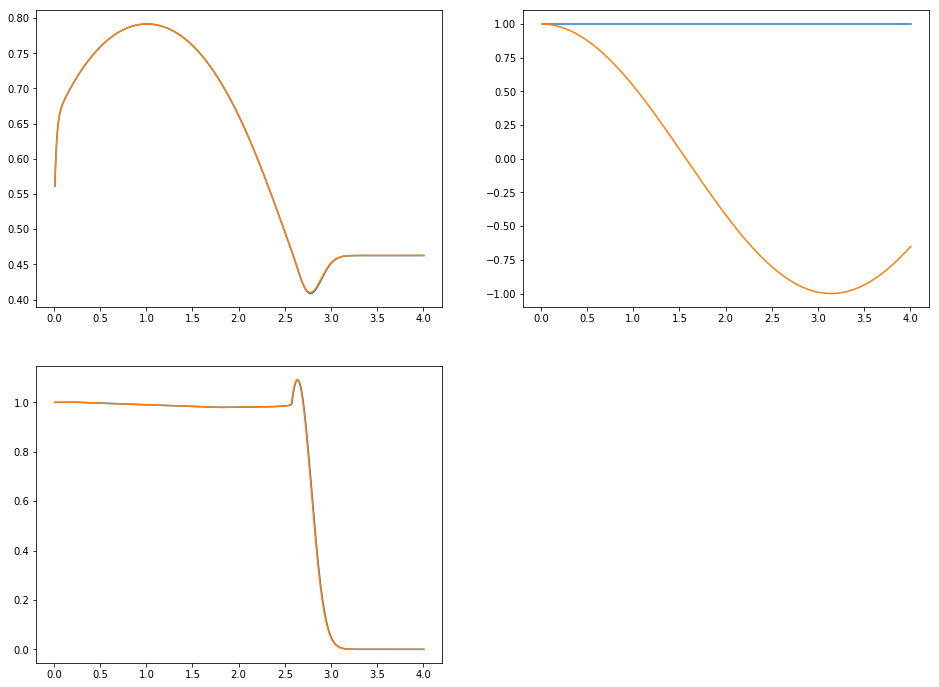

In [13]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax1.plot(times,units[ssrdc[0]], times, units[ssrdc_sharp[0]])
ax2.plot(times, units[shrp[0]], times, units[inp[0]])
ax3.plot(times, units[scale_track[0]], times, units[scale_track[1]])
plt.show()